#### Agenta
    1) Chatbot with LangGraph
    2) ReAct Architecture {reasoning + Acting}

#### Understanding react architecture
    * Basically reAct (reasoning + Acting), LLM acts as a brain and makes a decision whether to make a tool call or someother action based on the inputs. 

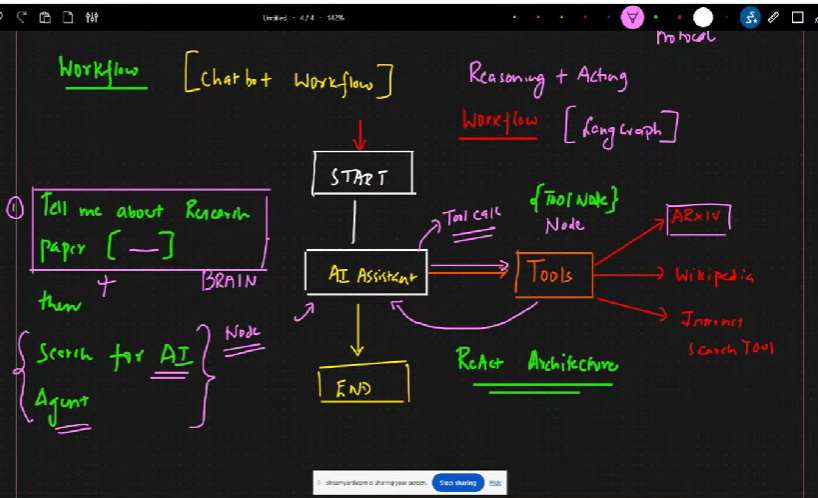

In [1]:
## tools
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
#Arxiv  tool - API to search research papers
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")
print(arxiv.name)


arxiv


In [3]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [4]:
#Wiki tool
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke("What is MCP?")

'Page: Model Context Protocol\nSummary: The Model Context Protocol (MCP) is an open standard and open-source framework introduced by Anthropic in November 2024 to standardize the way artificial intelligence (AI) systems like large language models (LLMs) integrate and share data with external tools, systems, and data sources. MCP provides a universal interface for reading files, executing functions, and handling contextual prompts. Following its announcement, the protocol was adopted by major AI pr'

In [6]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")


In [7]:
### Tavily search tool -  to search the web
#from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch

#tavily = TavilySearchResults()
tavily = TavilySearch()

In [8]:
tavily.invoke("Latest new about TVK party")

{'query': 'Latest new about TVK party',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://economictimes.indiatimes.com/topic/tvk',
   'title': 'Latest News & Videos, Photos about tvk - The Economic Times',
   'content': 'Tamilaga Vettri Kazhagam chief Vijay asserts his power-sharing proposal has become a political bomb in Tamil Nadu. He claims this offer is n... 13 Feb, 2026,',
   'score': 0.99861145,
   'raw_content': None},
  {'url': 'https://tvknews.org/',
   'title': 'Latest News, Photos, Videos on Tvk News - TVK NEWS',
   'content': 'TVKNews.org is your trusted source for Tamizhaga Vetri Kazhagam news, Thalapathy Vijay updates, Tamil Nadu politics, governance reports and election-focused',
   'score': 0.99589807,
   'raw_content': None},
  {'url': 'https://www.youtube.com/watch?v=7gONaSVnUxY',
   'title': "“No Tie-Up With Communal Forces” | Vijay's Party Signals - YouTube",
   'content': 'BreakingNews | Tamil Nadu politics sees a fresh dev

In [9]:
#combine all tool in the list
tools=[arxiv, wiki, tavily]

In [10]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen/qwen3-32b")

In [11]:
llm.invoke("What is python?")

AIMessage(content='<think>\nOkay, I need to explain what Python is. Let me start by recalling what I know. Python is a programming language, right? It\'s known for being easy to read and write. I think it was created in the late 80s or early 90s. Guido van Rossum is the creator, if I remember correctly. Python is used for a lot of things—web development, data analysis, artificial intelligence, scientific computing, automation, and more. It\'s versatile.\n\nI should mention that Python is high-level, which makes it accessible to beginners. Also, it\'s interpreted, so you don\'t need to compile it before running. The syntax uses indentation (whitespace) to define code blocks, which is different from languages like C++ or Java that use braces. That\'s a key point because it enforces a clean and readable code structure.\n\nPython has a large standard library and a huge ecosystem of third-party packages. Libraries like NumPy, pandas, TensorFlow, and Django come to mind. These make Python po

In [12]:
#binding the tools with the LLM
llm_with_tools=llm.bind_tools(tools=tools)

In [13]:
## Execute this call
#llm_with_tools.invoke("What is the recent new on TVK party?")

In [14]:
ai_msg=llm_with_tools.invoke("What is the latest research in quantum computing?")
vars(ai_msg)

{'content': '',
 'additional_kwargs': {'reasoning_content': 'Okay, the user is asking about the latest research in quantum computing. I need to figure out which tool to use here. The available tools are arxiv, wikipedia, and tavily_search. \n\nArxiv is great for academic papers, so that\'s probably the best bet for "latest research." Wikipedia might give general info but not the most recent studies. Tavily_search is a search engine, but the user specifically wants research, which is more likely to be on arxiv.\n\nSo I should call the arxiv function with a query for "quantum computing." The parameters for arxiv require a query string. Let me check if there are any other parameters needed. The arxiv function only requires the query, so I can proceed with that.\n\nWait, maybe I should consider if the user wants very recent papers. Arxiv does have preprints, which are often the latest. So the function call would be to arxiv with query "quantum computing." That should retrieve the latest pa

## Workflow

In [15]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage ## Human or AI message
from typing import Annotated ## labelling
from langgraph.graph.message import add_messages ## Reducers in Langgraph

In [16]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] ## add_messages append AI/Human msg interd of overriding it.
    

In [17]:
## Entire chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

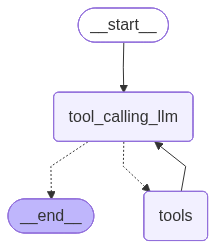

In [18]:
## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest msg from assistant is a tool call  -> tools_condition routes to tools
    # If the latest msg from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)

#builder.add_edge("tools", END) #

builder.add_edge("tools", "tool_calling_llm") #It will explain the reAct Architecture.
#Example given below, will explain

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
messages=graph.invoke({"messages":"What is Agentic AI and what is the lates research paper on agentic AI?"})
for msg in messages['messages']:
    msg.pretty_print()

#Below Example, has answers for two question which I have asked in a single promt.
#If you ovbserve you could see tool call is happend for two times, one in wiki tool call and another one in arxiv tool call

================================ Human Message =================================

What is Agentic AI and what is the lates research paper on agentic AI?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (ffcm76tth)
 Call ID: ffcm76tth
  Args:
    query: Agentic AI
  arxiv (gc7bx35x3)
 Call ID: gc7bx35x3
  Args:
    query: Agentic AI
================================= Tool Message =================================
Name: wikipedia

Page: AI agent
Summary: In the context of generative artificial intelligence, AI agents (also referred to as compound AI systems or agentic AI) are a class of intelligent agents distinguished by their ability to operate autonomously in complex environments. Agentic AI tools prioritize decision-making over content creation and do not require continuous oversight.
================================= Tool Message =================================
Name: arxiv

Published: 2025-11-20
Title: Trustworthy AI in the Ag

## Adding memeory to Agentic Graph

In [20]:
resp=graph.invoke({"messages":"Hi My name is suganth"})
for m in resp["messages"]:
    m.pretty_print()
    

================================ Human Message =================================

Hi My name is suganth
================================== Ai Message ==================================

Hello, Suganth! Welcome. How can I assist you today? Feel free to ask any questions or share what's on your mind. 😊


In [21]:
# It doesn't have the capablity of pressting the data.
resp=graph.invoke({"messages":"What is my name?"})
for m in resp["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I don't have access to personal information about users unless they explicitly provide it. Could you please tell me your name?


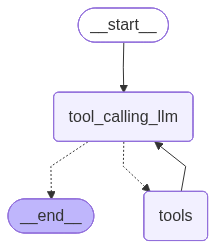

In [22]:
## To presist memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest msg from assistant is a tool call  -> tools_condition routes to tools
    # If the latest msg from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)

#builder.add_edge("tools", END) #

builder.add_edge("tools", "tool_calling_llm") #It will explain the reAct Architecture.
#Example given below, will explain

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
config={"configurable":{"thread_id":"1"}}
resp=graph.invoke({"messages":"My name is Suganth"}, config=config)
resp

{'messages': [HumanMessage(content='My name is Suganth', additional_kwargs={}, response_metadata={}, id='1ac08f42-b97a-4091-a80b-6f21e27af9e0'),
  AIMessage(content='Hello Suganth! How can I assist you today? If you have any questions or need help with something specific, feel free to let me know! 😊', additional_kwargs={'reasoning_content': 'Okay, the user said, "My name is Suganth." Let me think about how to respond.\n\nFirst, I need to acknowledge their introduction. A simple "Hello" or "Nice to meet you" would be appropriate. Since they provided their name, I should use it in the response to make it personal. Maybe something like, "Hello Suganth! How can I assist you today?" That\'s friendly and opens the door for them to ask questions or share more. \n\nI should check if there\'s any other information they might need help with. Since they only introduced themselves, there\'s no immediate query, but I should stay ready to assist with whatever they need next. No functions need to be 

In [24]:
resp['messages'][-1].content

'Hello Suganth! How can I assist you today? If you have any questions or need help with something specific, feel free to let me know! 😊'

In [25]:
resp=graph.invoke({"messages":"Hey What is my name?"}, config=config)
resp['messages'][-1].content

'Your name is Suganth! 😊'

## Streaming

In [26]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

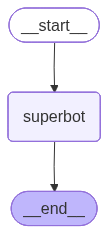

In [27]:
graph_builder = StateGraph(State)

graph_builder.add_node("superbot", superbot)

graph_builder.add_edge(START, "superbot")
graph_builder.add_edge("superbot", END)

mem = MemorySaver()

graph = graph_builder.compile(checkpointer=mem)

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
config = {"configurable":{"thread_id":"1"}}

graph.invoke({"messages":"Hi my name is Suganth and I love basketball"}, config=config)

{'messages': [HumanMessage(content='Hi my name is Suganth and I love basketball', additional_kwargs={}, response_metadata={}, id='794ce255-2665-4ecf-8227-18a7551bdc31'),
  AIMessage(content="<think>\nOkay, the user introduced himself as Suganth and mentioned he loves basketball. I need to respond in a friendly and engaging way. Let me start by acknowledging his name and interest.\n\nI should ask a follow-up question to keep the conversation going. Maybe ask about his favorite team or what he enjoys most about basketball. That way, I can learn more about his preferences and maybe find common ground.\n\nI should also consider possible follow-up topics. If he's into playing, I could ask about his position or any favorite players. If he's more into watching, maybe talk about recent games or events like the NBA season. It's good to stay open-ended so he can share what he's comfortable with. \n\nI need to make sure the tone is positive and encouraging. Using an emoji like 🏀 could add a frien

Methods: .stream() and astream()

    * Thse methids are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state

    * Value: This streams the full dtate of graph after each node in called.
    * update: This streams updates to the state of the graph after each node is called.

In [35]:
config = {"configurable":{"thread_id":"2"}}

for chunk in graph.stream({"messages":"Hi, My name is suganth and I like basketball"}, config, stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content='<think>\nOkay, the user keeps introducing themselves with the same message: "Hi, My name is suganth and I like basketball." They\'ve repeated this four times now. Let me figure out why that\'s happening.\n\nFirst, maybe they\'re testing if the response changes each time. But looking at my previous replies, I tailored each one a bit differently, asking about their interests, teams, or specific areas of basketball. However, they keep replying with the same initial message instead of answering the questions.\n\nAnother possibility is that they\'re having trouble responding properly. Maybe they\'re not sure how to continue the conversation or are using a platform where messages get duplicated. Or perhaps they\'re new to using chatbots and aren\'t clear on how to engage beyond the initial greeting.\n\nI should consider if there\'s a technical issue, like the message not sending correctly, so they keep resending it. Alternatively, they might just

In [36]:

for chunk in graph.stream({"messages":"Hi, My name is suganth and I like basketball"}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is suganth and I like basketball', additional_kwargs={}, response_metadata={}, id='7e7e8a04-5325-47e0-82c5-df2ed5b93816'), AIMessage(content="<think>\nOkay, the user mentioned their name is Suganth and they like basketball. I should respond in a friendly and engaging manner. I'll acknowledge their name and interest, and ask a follow-up question to continue the conversation. I want to make sure my response is warm and shows genuine interest in their passion for basketball.\n</think>\n\nHi Suganth! 🏀 That's awesome that you like basketball—I'm always up for a conversation about the game! Do you play often, or are you more of a fan watching your favorite teams or players? Let me know—I'd love to hear more!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 122, 'prompt_tokens': 19, 'total_tokens': 141, 'completion_time': 0.280880622, 'completion_tokens_details': None, 'prompt_time': 0.00063616, 'prompt_tokens_det